<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectif-:" data-toc-modified-id="Objectif-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectif :</a></span></li><li><span><a href="#Dev" data-toc-modified-id="Dev-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dev</a></span></li><li><span><a href="#Industrialisation" data-toc-modified-id="Industrialisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Industrialisation</a></span><ul class="toc-item"><li><span><a href="#Script" data-toc-modified-id="Script-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Script</a></span></li></ul></li><li><span><a href="#Analyse-de-la-feature" data-toc-modified-id="Analyse-de-la-feature-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyse de la feature</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-dépot-suivant-les-stations" data-toc-modified-id="Analyse-des-dépot-suivant-les-stations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Analyse des dépot suivant les stations</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import polars as pl
import seaborn as sns

from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.visualisation import plot_station_activity

sns.set_style("whitegrid")
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Objectif :

- Création d'une features afin de connaitre le nombre de prise de vélo qu'il y a eu pour une même station entre 2 points temporels. cf https://github.com/armgilles/vcub_keeper/issues/3 et https://github.com/armgilles/vcub_keeper/issues/116 (Polars migration).
- Industrialisation de la fonction
- Analyse des résultats

## Dev

In [2]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

In [3]:
activite.head()

In [4]:
activite.collect_schema().dtypes()

[UInt8,
 UInt8,
 Categorical(ordering='physical'),
 String,
 String,
 Int8,
 Int8,
 Datetime(time_unit='us', time_zone=None)]

In [5]:
available_stands_shift = pl.col("available_stands").shift(1).over("station_id").fill_null(pl.col("available_stands"))
transactions_out = pl.col("available_stands") - available_stands_shift

activite.with_columns(pl.when(transactions_out < 0).then(0).otherwise(transactions_out).alias("transactions_out"))

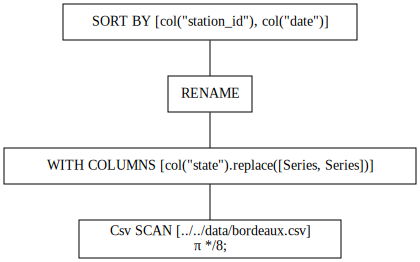

In [6]:
activite.show_graph()

In [7]:
activite.collect().head()

gid,station_id,type,name,state,available_stands,available_bikes,date
u8,u8,cat,str,str,i8,i8,datetime[μs]
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:03:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:04:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:09:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:14:03
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:19:04


## Industrialisation

In [8]:
from vcub_keeper.transform.features_factory import get_transactions_out

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Lecture de l'activité des stations
activite = read_activity_vcub()
activite = get_transactions_out(activite).collect()

In [10]:
%%timeit -r 10
activite = read_activity_vcub()
get_transactions_out(activite).collect()

773 ms ± 9.83 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [13]:
activite.slice(56020, 15)

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_out
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
41,3,"""VLS""","""Place Tartas""","""1""",17,1,2017-08-26 20:14:03,0
41,3,"""VLS""","""Place Tartas""","""1""",17,1,2017-08-26 20:19:05,0
41,3,"""VLS""","""Place Tartas""","""1""",17,1,2017-08-26 20:24:05,0
41,3,"""VLS""","""Place Tartas""","""1""",17,1,2017-08-26 20:29:03,0
41,3,"""VLS""","""Place Tartas""","""1""",18,0,2017-08-26 20:34:04,1
…,…,…,…,…,…,…,…,…
41,3,"""VLS""","""Place Tartas""","""1""",17,1,2017-08-26 21:04:04,0
41,3,"""VLS""","""Place Tartas""","""1""",17,1,2017-08-26 21:09:04,0
41,3,"""VLS""","""Place Tartas""","""1""",17,1,2017-08-26 21:14:04,0


### Script

In [14]:
from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.transform.features_factory import get_transactions_out

In [15]:
# Lecture de l'activité des stations
activite = read_activity_vcub()
activite = get_transactions_out(activite).collect()

In [16]:
activite.slice(136020, 15)

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_out
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
86,7,"""VLS""","""Palais de Justice""","""1""",12,6,2017-08-02 10:20:05,0
86,7,"""VLS""","""Palais de Justice""","""1""",13,5,2017-08-02 10:25:04,1
86,7,"""VLS""","""Palais de Justice""","""1""",15,3,2017-08-02 10:30:05,2
86,7,"""VLS""","""Palais de Justice""","""1""",15,3,2017-08-02 10:35:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",15,3,2017-08-02 10:40:03,0
…,…,…,…,…,…,…,…,…
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:25:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:30:06,0
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:35:04,0


## Analyse de la feature

In [17]:
# Lecture de l'activité des stations
activite = read_activity_vcub()
activite = get_transactions_out(activite).collect()

In [18]:
activite.head()

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_out
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:03:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:04:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:09:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:14:03,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:19:04,0


In [19]:
activite["transactions_out"].describe()
activite.select(pl.col("transactions_out")).describe()

statistic,transactions_out
str,f64
"""count""",3.76188e6
"""null_count""",0.0
"""mean""",0.129517
"""std""",0.502168
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",0.0
"""max""",36.0


<Axes: >

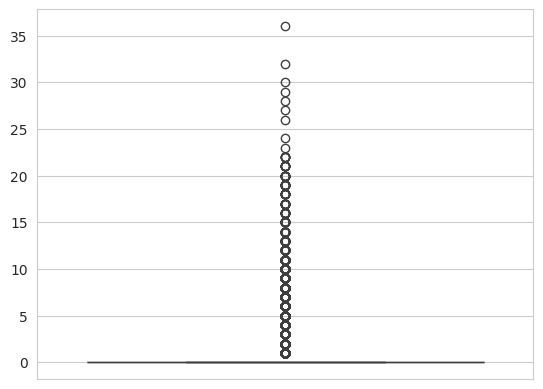

In [20]:
sns.boxplot(activite["transactions_out"])

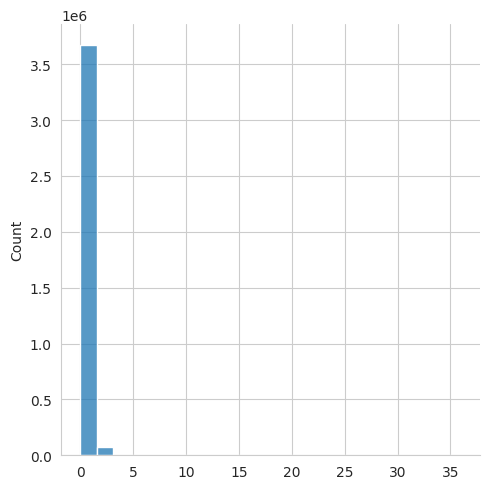

In [21]:
sns.displot(activite["transactions_out"])

### Analyse des dépot suivant les stations [OLD]

In [18]:
depot_by_station = activite.groupby("station_id", as_index=False)["transactions_out"].agg(
    {
        "max": "max",
        "mean": "mean",
        "median": "median",
        "min": "min",
        "std": "std",
        "var": "var",
        "skew": "skew",
        "25%": lambda x: x.quantile(0.25),
        "75%": lambda x: x.quantile(0.75),
        "95%": lambda x: x.quantile(0.95),
    }
)

depot_by_station.sort_values("mean", ascending=0, inplace=True)

In [19]:
# depot_by_station.sort_values('mean')
depot_by_station

,station_id,max,mean,median,min,std,var,skew,25%,75%,95%
105,106,22.0,0.580296,0.0,0.0,1.075433,1.156557,3.125303,0.0,1.0,3.0
4,5,22.0,0.459112,0.0,0.0,0.965352,0.931905,3.404881,0.0,1.0,2.0
21,22,26.0,0.437974,0.0,0.0,0.981720,0.963774,4.607333,0.0,1.0,2.0
122,123,28.0,0.419750,0.0,0.0,0.880893,0.775973,4.100431,0.0,1.0,2.0
38,39,24.0,0.417160,0.0,0.0,0.920862,0.847987,3.659573,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
159,160,3.0,0.001203,0.0,0.0,0.047104,0.002219,45.954761,0.0,0.0,0.0
75,76,1.0,0.000046,0.0,0.0,0.006801,0.000046,147.037410,0.0,0.0,0.0
92,93,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
34,35,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [ ]:
# Station les plus active sur les dépôt de vélo
plot_station_activity(activite, station_id=106, features_to_plot=["transactions_out"])

# Test

In [57]:
from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.transform.features_factory import get_transactions_out

In [58]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

In [59]:
activite = activite.with_columns(get_transactions_out()).collect()

In [60]:
activite.head(8)

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_out
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:03:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:04:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:09:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:14:03,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:19:04,0
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 00:24:05,1
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 00:29:04,0
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 00:34:04,0


In [10]:
# activite[(activite["transactions_out"] > 1) & (activite["date"] == "2017-07-09 11:09:04")].head()
# activite[(activite["date"] >= "2017-07-09 11:04:04") & (activite["station_id"] == 1)].head(11)#.to_dict(orient="list")
activite[(activite["date"] >= "2017-07-09 00:54:05") & (activite["station_id"] == 1)].head(
    11
)  # .to_dict(orient="list")

,gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_out
11,83,1,VLS,Meriadeck,1,19,1,2017-07-09 00:54:05,0.0
12,83,1,VLS,Meriadeck,1,19,1,2017-07-09 00:59:04,0.0
13,83,1,VLS,Meriadeck,1,19,1,2017-07-09 01:04:04,0.0
14,83,1,VLS,Meriadeck,1,19,1,2017-07-09 01:09:03,0.0
15,83,1,VLS,Meriadeck,1,19,1,2017-07-09 01:14:04,0.0
16,83,1,VLS,Meriadeck,1,20,0,2017-07-09 01:19:04,1.0
17,83,1,VLS,Meriadeck,1,20,0,2017-07-09 01:24:04,0.0
18,83,1,VLS,Meriadeck,1,20,0,2017-07-09 01:29:04,0.0
19,83,1,VLS,Meriadeck,1,20,0,2017-07-09 01:34:04,0.0
20,83,1,VLS,Meriadeck,1,20,0,2017-07-09 01:39:04,0.0


In [47]:
data = {
    "gid": [83] * 11 + [92] * 11,
    "station_id": [1] * 11 + [22] * 11,
    "type": ["VLS"] * 11 + ["VLS"] * 11,
    "name": ["Meriadeck"] * 11 + ["Hotel de Ville"] * 11,
    "state": [1] * 11 + [1] * 11,
    "available_stands": [11, 14, 14, 14, 15, 15, 17, 17, 17, 17, 18] + [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
    "available_bikes": [9, 6, 6, 6, 5, 5, 3, 3, 3, 3, 2] + [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
    "date": [
        pd.Timestamp("2017-07-09 11:04:04"),
        pd.Timestamp("2017-07-09 11:09:04"),
        pd.Timestamp("2017-07-09 11:14:04"),
        pd.Timestamp("2017-07-09 11:19:04"),
        pd.Timestamp("2017-07-09 11:24:04"),
        pd.Timestamp("2017-07-09 11:29:04"),
        pd.Timestamp("2017-07-09 11:34:04"),
        pd.Timestamp("2017-07-09 11:39:03"),
        pd.Timestamp("2017-07-09 11:44:03"),
        pd.Timestamp("2017-07-09 11:49:04"),
        pd.Timestamp("2017-07-09 11:54:05"),
    ]
    + [
        pd.Timestamp("2017-07-09 00:54:05"),
        pd.Timestamp("2017-07-09 00:59:04"),
        pd.Timestamp("2017-07-09 01:04:04"),
        pd.Timestamp("2017-07-09 01:09:03"),
        pd.Timestamp("2017-07-09 01:14:04"),
        pd.Timestamp("2017-07-09 01:19:04"),
        pd.Timestamp("2017-07-09 01:24:04"),
        pd.Timestamp("2017-07-09 01:29:04"),
        pd.Timestamp("2017-07-09 01:34:04"),
        pd.Timestamp("2017-07-09 01:39:04"),
        pd.Timestamp("2017-07-09 01:44:05"),
    ],
    "transactions_out": [0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0]
    + [0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
}

df_activite = pd.DataFrame(data)
# drop columns we want to test.
df_activite = df_activite.drop(columns=["transactions_out"], axis=1)

result = get_transactions_out(df_activite)

expected = pd.DataFrame(data)

pd.testing.assert_frame_equal(result, expected)

In [48]:
result

,gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_out
0,83,1,VLS,Meriadeck,1,11,9,2017-07-09 11:04:04,0.0
1,83,1,VLS,Meriadeck,1,14,6,2017-07-09 11:09:04,3.0
2,83,1,VLS,Meriadeck,1,14,6,2017-07-09 11:14:04,0.0
3,83,1,VLS,Meriadeck,1,14,6,2017-07-09 11:19:04,0.0
4,83,1,VLS,Meriadeck,1,15,5,2017-07-09 11:24:04,1.0
5,83,1,VLS,Meriadeck,1,15,5,2017-07-09 11:29:04,0.0
6,83,1,VLS,Meriadeck,1,17,3,2017-07-09 11:34:04,2.0
7,83,1,VLS,Meriadeck,1,17,3,2017-07-09 11:39:03,0.0
8,83,1,VLS,Meriadeck,1,17,3,2017-07-09 11:44:03,0.0
9,83,1,VLS,Meriadeck,1,17,3,2017-07-09 11:49:04,0.0


In [224]:
from polars.testing import assert_frame_equal

from vcub_keeper.transform.features_factory import get_transactions_out_

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
data = {
    "gid": [83] * 11 + [92] * 11,
    "station_id": [1] * 11 + [22] * 11,
    "type": ["VLS"] * 11 + ["VLS"] * 11,
    "name": ["Meriadeck"] * 11 + ["Hotel de Ville"] * 11,
    "state": [1] * 11 + [1] * 11,
    "available_stands": [11, 14, 14, 14, 15, 15, 17, 17, 17, 17, 18] + [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
    "available_bikes": [9, 6, 6, 6, 5, 5, 3, 3, 3, 3, 2] + [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
    "date": [
        pd.Timestamp("2017-07-09 11:04:04"),
        pd.Timestamp("2017-07-09 11:09:04"),
        pd.Timestamp("2017-07-09 11:14:04"),
        pd.Timestamp("2017-07-09 11:19:04"),
        pd.Timestamp("2017-07-09 11:24:04"),
        pd.Timestamp("2017-07-09 11:29:04"),
        pd.Timestamp("2017-07-09 11:34:04"),
        pd.Timestamp("2017-07-09 11:39:03"),
        pd.Timestamp("2017-07-09 11:44:03"),
        pd.Timestamp("2017-07-09 11:49:04"),
        pd.Timestamp("2017-07-09 11:54:05"),
    ]
    + [
        pd.Timestamp("2017-07-09 00:54:05"),
        pd.Timestamp("2017-07-09 00:59:04"),
        pd.Timestamp("2017-07-09 01:04:04"),
        pd.Timestamp("2017-07-09 01:09:03"),
        pd.Timestamp("2017-07-09 01:14:04"),
        pd.Timestamp("2017-07-09 01:19:04"),
        pd.Timestamp("2017-07-09 01:24:04"),
        pd.Timestamp("2017-07-09 01:29:04"),
        pd.Timestamp("2017-07-09 01:34:04"),
        pd.Timestamp("2017-07-09 01:39:04"),
        pd.Timestamp("2017-07-09 01:44:05"),
    ],
    "transactions_out": [0, 3, 0, 0, 1, 0, 2, 0, 0, 0, 1] + [0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0],
}

df_activite = pl.DataFrame(data)
# drop columns we want to test.
df_activite = df_activite.drop("transactions_out")

result = get_transactions_out_(df_activite)

expected = pl.DataFrame(data)

assert_frame_equal(result, expected)

In [231]:
# transactions_out
# transaction_out
result

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_out
i64,i64,str,str,i64,i64,i64,datetime[μs],i64
83,1,"""VLS""","""Meriadeck""",1,11,9,2017-07-09 11:04:04,0
83,1,"""VLS""","""Meriadeck""",1,14,6,2017-07-09 11:09:04,3
83,1,"""VLS""","""Meriadeck""",1,14,6,2017-07-09 11:14:04,0
83,1,"""VLS""","""Meriadeck""",1,14,6,2017-07-09 11:19:04,0
83,1,"""VLS""","""Meriadeck""",1,15,5,2017-07-09 11:24:04,1
…,…,…,…,…,…,…,…,…
92,22,"""VLS""","""Hotel de Ville""",1,33,0,2017-07-09 01:24:04,0
92,22,"""VLS""","""Hotel de Ville""",1,32,1,2017-07-09 01:29:04,0
92,22,"""VLS""","""Hotel de Ville""",1,33,0,2017-07-09 01:34:04,1


In [232]:
expected

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_out
i64,i64,str,str,i64,i64,i64,datetime[μs],f64
83,1,"""VLS""","""Meriadeck""",1,11,9,2017-07-09 11:04:04,0.0
83,1,"""VLS""","""Meriadeck""",1,14,6,2017-07-09 11:09:04,3.0
83,1,"""VLS""","""Meriadeck""",1,14,6,2017-07-09 11:14:04,0.0
83,1,"""VLS""","""Meriadeck""",1,14,6,2017-07-09 11:19:04,0.0
83,1,"""VLS""","""Meriadeck""",1,15,5,2017-07-09 11:24:04,1.0
…,…,…,…,…,…,…,…,…
92,22,"""VLS""","""Hotel de Ville""",1,33,0,2017-07-09 01:24:04,0.0
92,22,"""VLS""","""Hotel de Ville""",1,32,1,2017-07-09 01:29:04,0.0
92,22,"""VLS""","""Hotel de Ville""",1,33,0,2017-07-09 01:34:04,1.0
